In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from transformers import BertTokenizer
import torch
from transformers import BertForSequenceClassification, Trainer, TrainingArguments
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from utils import compute_metrics, explain_sentence
from transformers_interpret import SequenceClassificationExplainer
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, roc_auc_score
import torch.nn.functional as F

In [4]:
torch.cuda.empty_cache()

In [5]:
df = pd.read_csv('data/taxi_data_clean.csv')

In [6]:
label_encoder_role = LabelEncoder()
df['Role_encoded'] = label_encoder_role.fit_transform(df['Rider/Driver'])

In [7]:
train_texts, val_texts, train_labels, val_labels = train_test_split(
    df['Reviews'].tolist(),
    df['Role_encoded'].tolist(),
    test_size=0.2,
    random_state=42,
)

In [8]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
train_encodings_role = tokenizer(train_texts, truncation=True, padding=True, max_length=256)
val_encodings_role = tokenizer(val_texts, truncation=True, padding=True, max_length=256)

In [9]:
class ReviewsDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()} | {'labels': torch.tensor(self.labels[idx])}

    def __len__(self):
        return len(self.labels)

In [10]:
train_dataset_role = ReviewsDataset(train_encodings_role, train_labels)
val_dataset_role = ReviewsDataset(val_encodings_role, val_labels)

In [11]:
model_role = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=3)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [12]:
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    probs = F.softmax(torch.tensor(logits), dim=-1).numpy()
    preds = np.argmax(probs, axis=1)
    metrics = {
        'accuracy': accuracy_score(labels, preds),
        'precision_macro': precision_score(labels, preds, average='macro'),
        'recall_macro': recall_score(labels, preds, average='macro'),
        'f1_macro': f1_score(labels, preds, average='macro'),
        'f1_weighted': f1_score(labels, preds, average='weighted'),
    }
    # Only compute ROC AUC if all classes are present in labels
    try:
        if len(np.unique(labels)) == probs.shape[1]:
            metrics['roc_auc_ovr'] = roc_auc_score(labels, probs, multi_class='ovr', average='macro')
        else:
            metrics['roc_auc_ovr'] = None
    except Exception as e:
        metrics['roc_auc_ovr'] = None
    return metrics

In [13]:
training_args = TrainingArguments(
    output_dir='./results_role',
    evaluation_strategy="epoch",
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=3,
    weight_decay=0.01,
    logging_dir='./logs_role',
    logging_steps=50,
    report_to="none"
)

trainer_role = Trainer(
    model=model_role,
    args=training_args,
    train_dataset=train_dataset_role,
    eval_dataset=val_dataset_role,
    compute_metrics=compute_metrics  
)

c:\Users\Galyna\anaconda3\envs\ml2025\Lib\site-packages\transformers\training_args.py:1611: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [15]:
trainer_role.train()

Epoch,Training Loss,Validation Loss,Accuracy,Precision Macro,Recall Macro,F1 Macro,F1 Weighted,Roc Auc Ovr
1,0.164000,0.162312,0.958333,0.966454,0.860640,0.903953,0.955676,None
2,0.120200,0.191031,0.960784,0.936474,0.898030,0.915941,0.959881,None
3,0.024100,0.188244,0.965686,0.947494,0.908079,0.926449,0.964896,None


TrainOutput(global_step=612, training_loss=0.11658642793932528, metrics={'train_runtime': 294.5072, 'train_samples_per_second': 16.624, 'train_steps_per_second': 2.078, 'total_flos': 644101646598144.0, 'train_loss': 0.11658642793932528, 'epoch': 3.0})

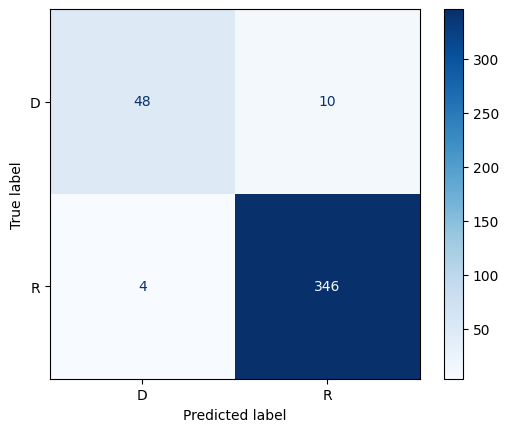

In [17]:
# Get predictions
predictions = trainer_role.predict(val_dataset_role)
preds = np.argmax(predictions.predictions, axis=1)
labels = predictions.label_ids

# Plot confusion matrix
cm = confusion_matrix(labels, preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder_role.classes_)
disp.plot(cmap='Blues')
plt.show()

In [18]:
def predict_role(review_text):
    inputs = tokenizer(review_text, return_tensors="pt", truncation=True, padding=True).to(model_role.device)
    with torch.no_grad():
        outputs = model_role(**inputs)
        probs = torch.nn.functional.softmax(outputs.logits, dim=-1)
        predicted = torch.argmax(probs, dim=-1).item()
        return label_encoder_role.inverse_transform([predicted])[0]

# Example
print(predict_role("I picked up a passenger and drove them to the airport."))

R
